# Modelling Customer Churn 2 - Visualising and Analysing Data

## A. P. Young

### 2022-04-02

In [1]:
import time
START = time.time()
import datetime
from datetime import timedelta
import pandas as pd
from collections import Counter
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Introduction

We want to model and understand the reasons behind customer churn. **Customer churn** refers to when customers have voluntarily stopped using a business' services within a given time window, usually expressed as a rate or a percentage. Usually, it is more expensive for businesses to acquire new customers than keep existing customers. Therefore, measuring, modelling and understanding customer churn is important for businesses, especially in industries where churn rate is high (e.g. mobile phones, insurance, internet service providers... etc.)

For more details, see https://www.investopedia.com/terms/c/churnrate.asp (last accessed 3/4/2022)

The dataset is from Kaggle - https://www.kaggle.com/datasets/blastchar/telco-customer-churn (last accessed 2/4/2022).

We get the data - the data has already been cleaned (i.e. every value is numerical, and there are no missing values) in the preceding notebook.

In [2]:
data = pd.read_csv('customer_churn_cleaned.csv')

In [3]:
data.shape

(7043, 26)

In [4]:
data

,is_female,SeniorCitizen,Partner,Dependents,tenure/month,PhoneService,MultipleLines,internet_service_is_dsl,internet_service_is_fiber_optic,OnlineSecurity,...,Contract_is_one_year,Contract_is_two_year,PaperlessBilling,PaymentMethod_is_electronic_check,PaymentMethod_is_mailed_check,PaymentMethod_is_bank_transfer,PaymentMethod_is_credit_card,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,29.85,29.85,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,56.95,1889.50,0
2,0,0,0,0,2,1,0,1,0,1,...,0,0,1,0,1,0,0,53.85,108.15,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,0,1,0,42.30,1840.75,0
4,1,0,0,0,2,1,0,0,1,0,...,0,0,1,1,0,0,0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,...,1,0,1,0,1,0,0,84.80,1990.50,0
7039,1,0,1,1,72,1,1,0,1,0,...,1,0,1,0,0,0,1,103.20,7362.90,0
7040,1,0,1,1,11,0,0,1,0,1,...,0,0,1,1,0,0,0,29.60,346.45,0
7041,0,1,1,0,4,1,1,0,1,0,...,0,0,1,0,1,0,0,74.40,306.60,1


# Visualising the Distributions of Values

We check the distributions of values for each column.

## Boolean Features

First, for the Booleans. We have the following helper function:

In [5]:
def count_and_perentage_of_Boolean_features(mydf):
    """
    Input dataframe
    Output dataframe where each row is a Boolean feature
    and we have raw counts of 0 and 1, as well as their percentages
    NOTE THE DATAFRAME BOOLEANS HAVE VALUES 0 AND 1
    (not "yes", "no"... etc.)
    """
    answer = []
    # go through each feature
    for feature in list(mydf):
        mycol = mydf[feature]
        value_counts = dict(Counter(mycol))
        # if there are exactly two distinct values
        if len(value_counts) == 2:
            # we count those values
            value_counts['feature'] = feature
            answer.append(value_counts)
    answer = pd.DataFrame(answer)
    # sort columns
    answer = answer[['feature', 0, 1]]
    answer = answer.set_index('feature')
    # give fractions of each class
    answer['%0'] = answer[0] / answer.sum(axis = 1)
    answer['%1'] = answer[1] / answer.sum(axis = 1)
    return answer

We apply the function:

In [6]:
booleans_df = count_and_perentage_of_Boolean_features(data)

In [7]:
booleans_df

,0,1,%0,%1
feature,,,,
is_female,3555,3488,0.504756,0.495208
SeniorCitizen,5901,1142,0.837853,0.162128
Partner,3641,3402,0.516967,0.482997
Dependents,4933,2110,0.700412,0.299558
PhoneService,682,6361,0.096834,0.903154
MultipleLines,4072,2971,0.578163,0.421803
internet_service_is_dsl,4622,2421,0.656254,0.343714
internet_service_is_fiber_optic,3947,3096,0.560415,0.439550
OnlineSecurity,5024,2019,0.713332,0.286639


The most important observation is that `Churn`, the target variable, is not balanced - it is $73\%$ negative and $27\%$ positive, which could be a realistic level of churn (given that often only a minority of customers cancel their subscriptions).

For model training purposes, we would need to balance the classes, either downsampling the majority or upsampling (copying) the minority class, for the usual reasons (e.g. misleading accuracy, overfitting... etc.).

The imbalance is mild though, around $1:3$.

**Conclusion 1:** We need to balance the dependent variable either by downsampling or upsampling.

## Non-Boolean Features

As for the non-Booleans features:

In [8]:
non_Boolean_features = [col for col in list(data) if col not in list(booleans_df.index)]

In [9]:
non_Boolean_features

['tenure/month', 'MonthlyCharges', 'TotalCharges']

We visualise their distributions:

In [10]:
index = 0
data[non_Boolean_features[index]].plot.hist(figsize = (12, 6),
                                        title = 'Distribution of ' + non_Boolean_features[index],
                                        bins = 100)

Tenure in months shows that there are many customers with very short tenures, and also many customers with very long tenures, and an "even" part in the middle.

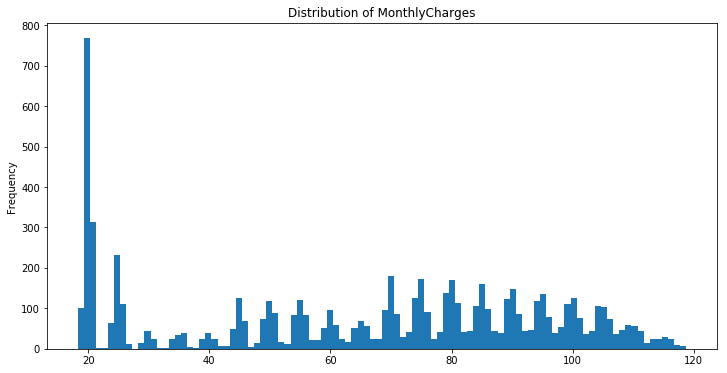

In [11]:
index = 1
data[non_Boolean_features[index]].plot.hist(figsize = (12, 6),
                                        title = 'Distribution of ' + non_Boolean_features[index],
                                        bins = 100)

Distribution of montly charges have this "bumpy" structure perhaps because this is calculated as an average of charges per month.

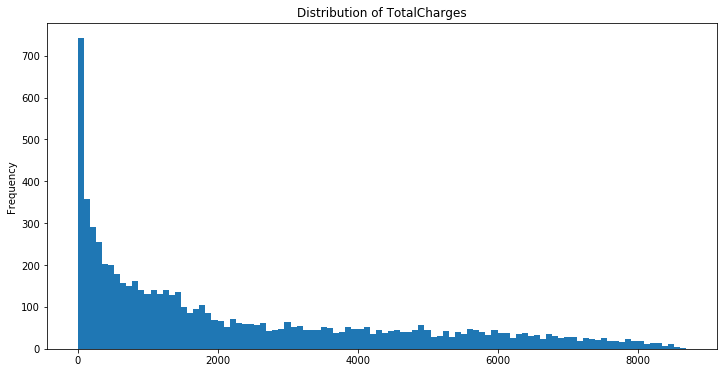

In [12]:
index = 2
data[non_Boolean_features[index]].plot.hist(figsize = (12, 6),
                                        title = 'Distribution of ' + non_Boolean_features[index],
                                        bins = 100)

There are many customers who pay very little, but then there is a "slow" decrease in the number of customers as the total charges increase.

# Correlations Between Features

We can examine the (Pearson) correlations between features. This is to detect multicollinearity. As the standard `.corr()` matrix from a dataframe is hard to read, we write a helper function to "unroll" the correlation matrix into distinct pairs of features.

In [13]:
def unroll_correlation_matrix(mydf):
    """
    Input correlation matrix dataframe (dataframe.corr())
    Output dataframe with (Pearson) correlations between all distinct columns
    Sorted from highest to lowest value of correlation
    """
    answer = []
    size = mydf.shape[0]
    for index1 in range(size):
        for index2 in range(index1 + 1, size):
            col1 = list(mydf)[index1]
            col2 = list(mydf)[index2]
            correlation = mydf.loc[col1][col2]
            myrow = {'column1' : col1,
                     'column2' : col2,
                     'correlation' : correlation}
            answer.append(myrow)
    return pd.DataFrame(answer).sort_values(by = 'correlation', ascending = False).reset_index(drop = True)

In [14]:
correlations_df = unroll_correlation_matrix(data.corr())

In [15]:
correlations_df

,column1,column2,correlation
0,tenure/month,TotalCharges,0.826178
1,internet_service_is_fiber_optic,MonthlyCharges,0.787066
2,MonthlyCharges,TotalCharges,0.651174
3,StreamingTV,MonthlyCharges,0.629603
4,StreamingMovies,MonthlyCharges,0.627429
...,...,...,...
320,PhoneService,internet_service_is_dsl,-0.452425
321,Contract_is_month-to-month,Contract_is_one_year,-0.568744
322,Contract_is_month-to-month,Contract_is_two_year,-0.622633
323,internet_service_is_dsl,internet_service_is_fiber_optic,-0.640987


Many of of these correlations are common-sensical, e.g. the longer the tenure the more the total charges, and extra services or service features such as fiber optic cables, streaming TV and movies, device protection... etc. will raise either monthly charges or total charges. Also, churn is somewhat correlated with the contract being monthly.

We use the heuristic that any correlation whose magnitude is larger than $0.7$ indicates the presence of multicollinearity, see https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a (last acessed 2/4/2022).

In [16]:
strong_correlations_df = correlations_df[(correlations_df['correlation'] > 0.7)|(correlations_df['correlation'] < -0.7)]

In [17]:
strong_correlations_df

,column1,column2,correlation
0,tenure/month,TotalCharges,0.826178
1,internet_service_is_fiber_optic,MonthlyCharges,0.787066


We plot the scatter plots between the first of the above two pairs of features (as both features are not Boolean):

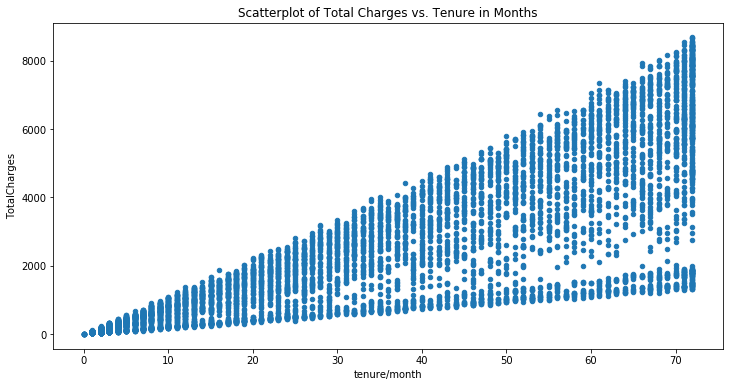

In [18]:
data.plot.scatter(x = 'tenure/month',
                  y = 'TotalCharges',
                  figsize = (12, 6),
                  title = 'Scatterplot of Total Charges vs. Tenure in Months')

Which one feature in each of the two pairs should we eliminate? It seems we should keep `TotalCharges` and `MonthlyCharges` as both are not Boolean, but that is a weak argument. Can `tenure/month` be inferred by the ratio of `TotalCharges` to `MonthlyCharges`?

In [19]:
compare_monthly_tenure = data['TotalCharges'] / data['MonthlyCharges'] - data['tenure/month']

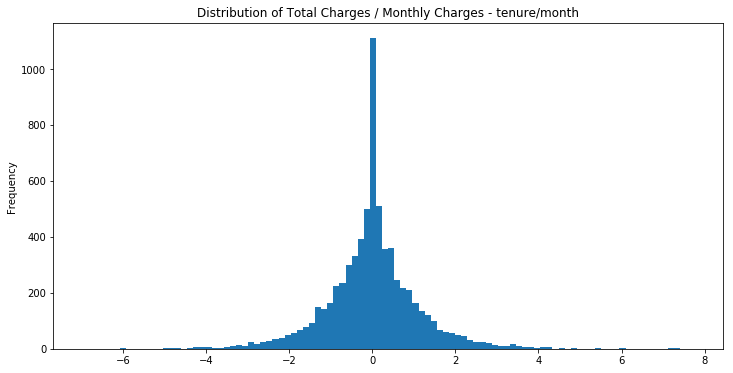

In [20]:
compare_monthly_tenure.plot.hist(bins = 100,
                                 figsize = (12,6),
                                 title = 'Distribution of Total Charges / Monthly Charges - tenure/month')

It seems that there is a concentration around zero but there is also a lot of error.

In [21]:
compare_monthly_tenure.describe()

count    7043.000000
mean        0.002282
std         1.135584
min        -6.941748
25%        -0.517380
50%         0.000000
75%         0.488900
max         7.706941
dtype: float64

Indeed, the average value is close to zero but there is a large range of the deviation from around $-7$ to $7.7$.

The skewness is positive, so we do not get exact symmetry around zero here.

In [22]:
skew(compare_monthly_tenure)

0.17202712479214038

The point is that `tenure/month` cannot be recovered exactly through `TotalCharges` and `MonthlyCharges`.

We try a more formal approach using the variance inflation factor (VIF). See https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/ (last accessed 2/4/2022). Intuitively this is a measure of how much each input feature is correlated with all other input features.

We only get the input columns.

In [23]:
data_X = data[list(data)[:-1]]

We construct the VIF dataframe:

In [24]:
vif_data = pd.DataFrame()
vif_data['feature'] = data_X.columns
vif_data['vif'] = [variance_inflation_factor(data_X.values, i) for i in range(len(data_X.columns))]

/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [25]:
vif_data = vif_data.sort_values(by = 'vif').reset_index(drop = True)

In [26]:
vif_data

,feature,vif
0,is_female,1.002137
1,SeniorCitizen,1.153365
2,PaperlessBilling,1.209020
3,Dependents,1.384430
4,Partner,1.462701
5,OnlineSecurity,6.336249
6,TechSupport,6.467893
7,OnlineBackup,6.782866
8,DeviceProtection,6.922434
9,MultipleLines,7.273906


Notice that VIF is infinite for some features as it is defined as $\frac{1}{1-R^2}$, where $R^2$ is an appropriate coefficient of determination of that feature. The point is that the larger the VIF, the more correlated it is with other features overall. However, referring back to our original correlation matrix, out of the highly correlated features here:

In [27]:
strong_correlations_df

,column1,column2,correlation
0,tenure/month,TotalCharges,0.826178
1,internet_service_is_fiber_optic,MonthlyCharges,0.787066


We should eliminate the feature in each pair with the highest VIF, which according to the above table are `TotalCharges` and `MonthlyCharges`. However, it seems undesirable to eliminate both features that involve how much a customer is paying. Therefore, we will get rid of `internet_service_is_fiber_optic` instead of `MonthlyCharges`. Getting rid of `TotalCharges` loses information as we cannot exactly reconstruct its values from `MonthlyCharges` and `tenure/month` as shown above.

**N.B.** Perhaps this argument as to which features to eliminate is not very principled, but we will proceed as given.

# Conclusions

In our above analysis, we will perform the following prior to modelling:

  1. Balance out both classes of `Churn`, either by downsampling the majority class or upsampling the minority class.
  
  2. Get rid of the input features `internet_service_is_fiber_optic` and `TotalCharges` to resolve multicollinearity.
  
Note that the second point is relevant as we plan to model this data with logistic regression. However, multicollinearity is not so much of a problem for, e.g. random forest (see https://stats.stackexchange.com/questions/141619/wont-highly-correlated-variables-in-random-forest-distort-accuracy-and-feature, last accessed 2/4/2022). But we wish to compare various machine learning models on the same dataset, so we will also get rid of the above two features for models where multicollinearity is not much of a problem.

In the next notebook, we will train and tune five models to predict churn, and apply SHAP on the most accurate model to identify the most important features influencing churn.

In [28]:
"Notebook done in " + str(datetime.timedelta(seconds=time.time() - START)) + "."

'Notebook done in 0:00:07.781951.'